In [13]:
%pip install spacy
%pip install scikit-learn
%pip install networkx
%pip install matplotlib
# %pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_md-3.7.1/en_core_web_md-3.7.1-py3-none-any.whl
%pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_lg-3.7.1/en_core_web_lg-3.7.1-py3-none-any.whl


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━ 226.2/587.7 MB 7.7 MB/s eta 0:00:47^C
Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/geo/Documents/prgm/connections-solver/.venv/li

In [1]:
import numpy as np
import networkx as nx
from sklearn.cluster import SpectralClustering
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import spacy

In [2]:
class NYTConnectionsSolver:
    def __init__(self, words, attention_model=None, device='cpu'):
        if len(set(words)) != len(words):
            raise ValueError("Duplicate words are not allowed.")
        if len(words) != 16: # maybe adjust this to allow for nxn
            raise ValueError("Expected 16 words for NYT Connections game.")
        
        words = [word.lower() for word in words]

        self.words = words
        self.solved_groups = []
        self.unsolved_words = words
        self.attention_model = attention_model
        self.device = device
        
        self.nlp = spacy.load("en_core_web_lg")

        word_vectors_list = [self.nlp(word).vector for word in words]
        if attention_model:
            self.attention_model.to(self.device).eval()
            with torch.no_grad():
                base_vectors = torch.tensor(word_vectors_list, dtype=torch.float32).to(self.device)
                enhanced_vectors = attention_model(base_vectors).cpu().numpy()
        else:
            enhanced_vectors = np.array(word_vectors_list)


        self.word_vectors = dict(zip(words, enhanced_vectors))
        
        sim_matrix = cosine_similarity(
            np.array(list(self.word_vectors.values())) # it'd be nice if the cosine similarity function could take a dict
        )
        sim_matrix = np.maximum(sim_matrix, 0)

        np.fill_diagonal(sim_matrix, 0) # no self-loops
        self.graph = nx.from_numpy_array(sim_matrix, nodelist=words)

        self.guesses = {}
    
    def preprocess_words(self, words):
        words = [word.lower() for word in words]
        return words


    def remove_group(self, group):
        """Mark a group as solved and remove its connections to the rest."""
        if len(group) != 4:
            raise ValueError("Group must contain 4 words.")
        if not all(word in self.unsolved_words for word in group):
            print(group, len(group))
            print(self.unsolved_words, len(self.unsolved_words))
            raise ValueError("All words in the group must be unsolved.")
        
        self.solved_groups.append(group)
        for word in group:
            self.unsolved_words.remove(word)
            for other in self.graph.nodes:
                if other not in group and self.graph.has_edge(word, other):
                    self.graph.remove_edge(word, other)

    def suggest_partition_general(self):
        """Suggest the best partition of remaining unsolved words into groups."""
        words = list(self.unsolved_words)
        if len(words) % 4 != 0:
            raise ValueError("Number of unsolved words must be divisible by 4.")
        
        sim_matrix = nx.to_numpy_array(self.graph, nodelist=words, weight='weight')
        
        n_clusters = len(words) // 4
        clustering = SpectralClustering(
            n_clusters=n_clusters, affinity='precomputed'
        )
        labels = clustering.fit_predict(sim_matrix)
        
        groups = [[] for _ in range(n_clusters)]
        for word, label in zip(words, labels):
            groups[label].append(word)
        
        return groups
    
    def suggest_partition(self):
        """Suggest the best partition of remaining unsolved words into groups of 4."""
        if len(self.unsolved_words) % 4 != 0:
            raise ValueError("Number of unsolved words must be divisible by 4.")
        if len(self.unsolved_words) == 0:
            return []

        groups = self.suggest_partition_general()

        if all(len(group) == 4 for group in groups):
            return groups    

        oversized = [g for g in groups if len(g) > 4]
        undersized = [g for g in groups if len(g) < 4]
        valid_groups = [g for g in groups if len(g) == 4]

        while oversized and undersized:
            for over in oversized:
                if not undersized:
                    break

                word_to_move = None
                best_score = -1
                target_group = None

                for word in over:
                    for group in undersized:
                        sim = np.mean([
                            self.graph[word][w]['weight']
                            if self.graph.has_edge(word, w) else 0
                            for w in group
                        ])
                        if sim > best_score:
                            best_score = sim
                            word_to_move = word
                            target_group = group

                if word_to_move and target_group is not None:
                    over.remove(word_to_move)
                    target_group.append(word_to_move)
                    if len(target_group) == 4:
                        valid_groups.append(target_group)
                        undersized.remove(target_group)
                    if len(over) == 4:
                        valid_groups.append(over)
                        oversized.remove(over)

        return valid_groups
    

    def input_guess(self, guess, away=0):
        """Takes a guess and how away it was from an answer and update the graph."""
        if away >= 3:
            raise ValueError("Away must be between 0 and 3.")
        guess = self.preprocess_words(guess)
        self.guesses[tuple(sorted(guess))] = away
        if away == 0:
            self.remove_group(guess)

        if len(self.unsolved_words) == 4:
            self.remove_group(self.unsolved_words)
    
    def solve_one(self):
        groups = self.suggest_partition()

        best_group = None
        best_score = -1
        for group in groups:
            score = np.mean([
                self.graph[w1][w2]['weight'] 
                if i < j and self.graph.has_edge(w1, w2) else 0
                for i, w1 in enumerate(group)
                for j, w2 in enumerate(group)
            ])
            if score > best_score:
                best_score = score
                best_group = group
        if best_group is not None:
            self.remove_group(best_group)
        else:
            raise ValueError("No valid group found.")
    
    def solve(self):
        """Solve the NYT Connections game."""
        
        while len(self.unsolved_words) > 0:
            self.solve_one()
        return self.solved_groups

    def visualize(self):
        """Visualize the current state of the graph."""
        pos = nx.spring_layout(self.graph)
        groups = self.solved_groups + self.suggest_partition()
        colors = ['#F9DF6D', '#A0C359', '#B0C4EF', '#B981C7']
        for i, group in enumerate(groups):
            color = colors[i % len(colors)]
            # nx.draw_networkx_nodes(self.graph, pos, nodelist=group, node_color=color)
            nx.draw(self.graph, pos, nodelist=group, with_labels=True, node_size=200, node_color=color, edge_color='#efefe7')
        plt.show()


    def print_board(self):
        """Print the current state of the board, enclosed in a box."""
        def color_word(word, color):
            color_code = 0
            if color == 'yellow':
                color_code = 33
            elif color == 'green':
                color_code = 32
            elif color == 'blue':
                color_code = 34
            elif color == 'purple':
                color_code = 35
            else:
                color_code = 37
            return f"\033[{color_code}m{word}\033[0m"
        
        color_list = ['yellow', 'green', 'blue', 'purple']
        
        all_groups = self.solved_groups + self.suggest_partition()
        
        max_lengths = [0, 0, 0, 0]  # assumes 4 words per group
        for group in all_groups:
            for i, word in enumerate(group):
                max_lengths[i] = max(max_lengths[i], len(word.upper()))
        
        formatted_lines = []
        
        for i, group in enumerate(all_groups):
            padded_words = []
            for j, word in enumerate(group):
                padded_word = word.upper().ljust(max_lengths[j])
                padded_words.append(padded_word)
                
            group_text = "    ".join(padded_words)
            
            if i < len(self.solved_groups):
                color = color_list[i % len(color_list)]
            else:
                color = 'white'
                
            formatted_lines.append((group_text, color))
        
        max_line_length = max(len(line) for line, _ in formatted_lines) if formatted_lines else 0
        box_width = max_line_length + 4 # 2 for padding, 2 for box edges
        
        print("┌" + "─" * (box_width - 2) + "┐") # top
        
        for line_text, color in formatted_lines:
            padding = " " * (box_width - 3 - len(line_text))
            
            # Print the line with color and proper padding
            print("│ " + color_word(line_text, color) + padding + "│")
        
        print("└" + "─" * (box_width - 2) + "┘") # bottom

Initial Suggested Groups:
┌────────────────────────────────────┐
│ CAR      TRAIN     PLANE    BIKE   │
│ DOG      CAT       MOUSE    RABBIT │
│ APPLE    BANANA    GRAPE    ORANGE │
│ BLUE     RED       GREEN    YELLOW │
└────────────────────────────────────┘


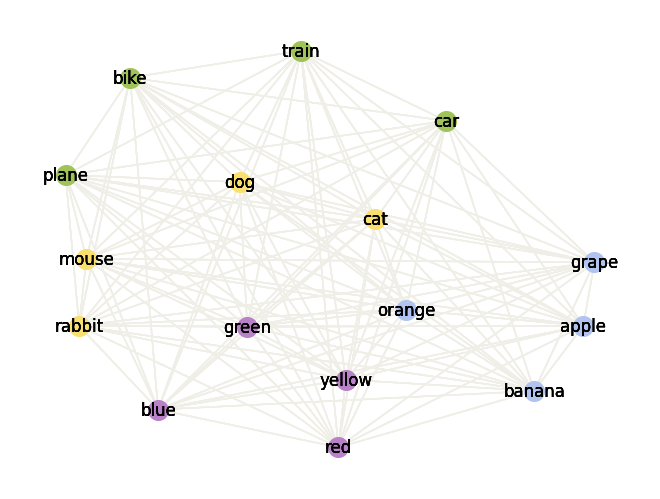

┌─────────────────────────────────────┐
│ APPLE    BANANA    ORANGE    GRAPE  │
│ BLUE     RED       GREEN     YELLOW │
│ CAR      TRAIN     PLANE     BIKE   │
│ DOG      CAT       MOUSE     RABBIT │
└─────────────────────────────────────┘


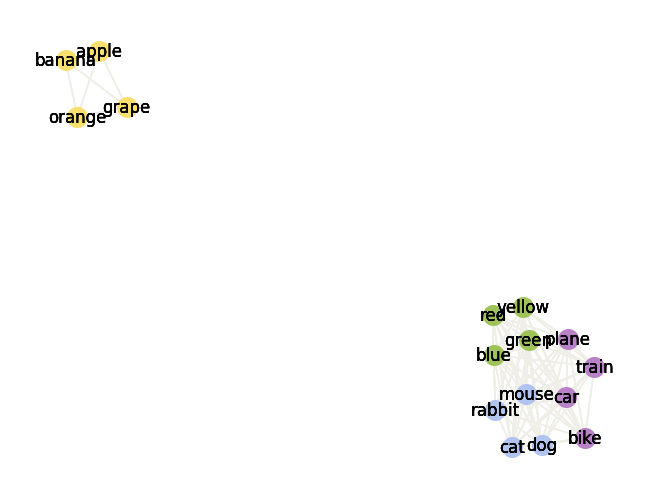

┌─────────────────────────────────────┐
│ APPLE    BANANA    ORANGE    GRAPE  │
│ BLUE     RED       GREEN     YELLOW │
│ DOG      CAT       MOUSE     RABBIT │
│ CAR      TRAIN     PLANE     BIKE   │
└─────────────────────────────────────┘


In [3]:
# Sample Connections
words = [
    "apple", "banana", "orange", "grape",
    "blue", "red", "green", "yellow",
    "car", "train", "plane", "bike",
    "dog", "cat", "mouse", "rabbit"
]

solver = NYTConnectionsSolver(words)
print("Initial Suggested Groups:")
solver.print_board()

solver.visualize()

# inputing a correct guess:
solver.input_guess(["apple", "banana", "orange", "grape"])

solver.print_board()
solver.visualize()

solver.solve()
solver.print_board()

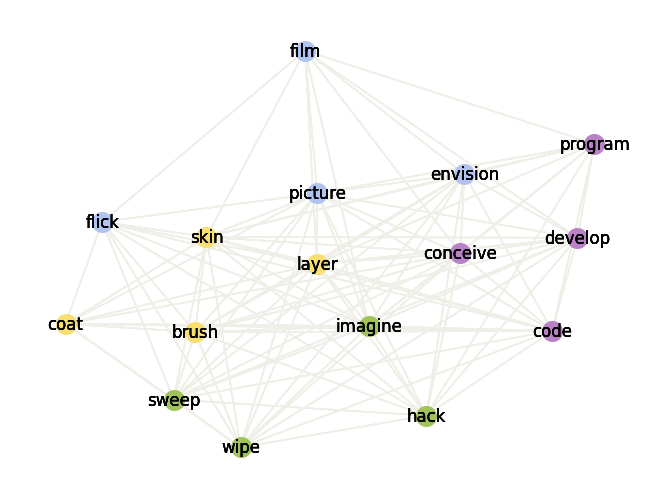

Solved Groups:
┌─────────────────────────────────────────┐
│ COAT       BRUSH      SKIN     LAYER    │
│ DEVELOP    PROGRAM    CODE     CONCEIVE │
│ SWEEP      WIPE       HACK     IMAGINE  │
│ FILM       PICTURE    FLICK    ENVISION │
└─────────────────────────────────────────┘


In [4]:
# Actual NYT Connections
words = [
    "coat", "brush", "develop", "film",
    "sweep", "picture", "skin", "flick",
    "imagine", "layer", "program", "code",
    "wipe", "conceive", "hack", "envision"
]

solver = NYTConnectionsSolver(words)

solver.visualize()
groups = solver.solve()
print("Solved Groups:")
solver.print_board()

# Attention based ideas

In [5]:
%pip instal torch
%pip install pandas

ERROR: unknown command "instal" - maybe you meant "install"
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import pandas as pd

In [14]:
class ConnectionsDataset(Dataset):
    def __init__(self, puzzles):
        self.puzzles = puzzles
        self.nlp = spacy.load("en_core_web_lg")
        self.vector_dim = self.nlp("word").vector.shape[0]

        self.puzzle_vectors = []
        self.puzzle_labels = []
        for groups in puzzles:
            words = [word for group in groups for word in group]
            vectors = torch.tensor([self.nlp(word).vector for word in words], dtype=torch.float32)
            labels = torch.tensor([i for i, group in enumerate(groups) for _ in group], dtype=torch.long)
            self.puzzle_vectors.append(vectors)
            self.puzzle_labels.append(labels)
        self.puzzle_vectors = torch.stack(self.puzzle_vectors)
        self.puzzle_labels = torch.stack(self.puzzle_labels)
        self.puzzles = [(self.puzzle_vectors[i], self.puzzle_labels[i]) for i in range(len(puzzles))]

    def __len__(self):
        return len(self.puzzles)

    def __getitem__(self, idx):
        vectors, labels = self.puzzles[idx]
        return vectors, labels


class AttentionModel(nn.Module):
    def __init__(self, input_dim, attention_dim):
        super().__init__()
        self.W_Q = nn.Linear(input_dim, attention_dim)
        self.W_K = nn.Linear(input_dim, attention_dim)
        self.W_V = nn.Linear(input_dim, attention_dim)
        self.output = nn.Linear(attention_dim, input_dim)  # project back to input space

    def forward(self, X):
        Q = self.W_Q(X)
        K = self.W_K(X)
        V = self.W_V(X)

        scores = torch.matmul(Q, K.transpose(0, 1)) / (K.shape[-1] ** 0.5)
        weights = torch.softmax(scores, dim=-1)
        attended = torch.matmul(weights, V)
        return self.output(attended) + X  # residual connection

    

def group_triplets(embeddings, labels):
    """Generate anchor-positive-negative triplets for training."""
    triplets = []
    n = labels.shape[0]
    for i in range(n):
        for j in range(i+1, n):
            if labels[i] == labels[j]:  # same group
                anchor, positive = embeddings[i], embeddings[j]
                # find a negative example (different group)
                for k in range(n):
                    if labels[k] != labels[i]:
                        negative = embeddings[k]
                        triplets.append((anchor, positive, negative))
    return triplets

def compute_triplet_loss(embeddings, labels, margin=0.2):
    loss_fn = nn.TripletMarginLoss(margin=margin)
    triplets = group_triplets(embeddings, labels)
    if not triplets:
        return torch.tensor(0.0, requires_grad=True)
    
    loss = torch.stack([
        loss_fn(a.unsqueeze(0), p.unsqueeze(0), n.unsqueeze(0))
        for a, p, n in triplets
    ]).mean()
    return loss


def train_attention_model(dataset, model, epochs=10, batch_size=1, lr=1e-3):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        total_loss = 0
        for vectors, labels in dataloader:
            vectors, labels = vectors.squeeze(0), labels.squeeze(0)  # batch_size = 1
            optimizer.zero_grad()
            attended = model(vectors)
            loss = compute_triplet_loss(attended, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")
    

In [8]:
df = pd.read_csv("./Connections_Data.csv")
puzzles = []
for game_id, game in df.groupby("Game ID"):
    groups = []
    for group_id, group in game.groupby("Group Name"):
        words = group["Word"].tolist()
        groups.append(words)
    puzzles.append(groups)

In [9]:
test_size = .5
train_dataset = ConnectionsDataset(puzzles[:int(len(puzzles) * test_size)])
# test_dataset = ConnectionsDataset(puzzles[int(len(puzzles) * test_size):])

In [15]:
model = AttentionModel(train_dataset.vector_dim, 128)
train_attention_model(train_dataset, model, epochs=7, batch_size=1, lr=1e-3)

Epoch 1, Loss: 883.2692
Epoch 2, Loss: 855.1494
Epoch 3, Loss: 847.8076
Epoch 4, Loss: 834.6106
Epoch 5, Loss: 819.7309
Epoch 6, Loss: 825.2494
Epoch 7, Loss: 818.0333


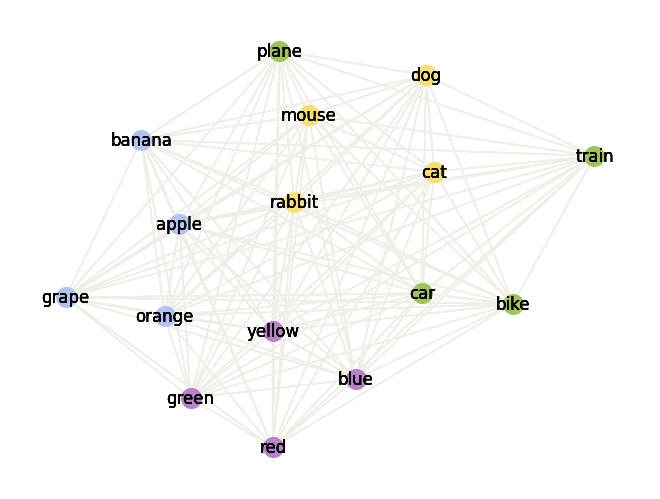

┌────────────────────────────────────┐
│ DOG      CAT       MOUSE    RABBIT │
│ CAR      TRAIN     PLANE    BIKE   │
│ APPLE    BANANA    GRAPE    ORANGE │
│ BLUE     RED       GREEN    YELLOW │
└────────────────────────────────────┘


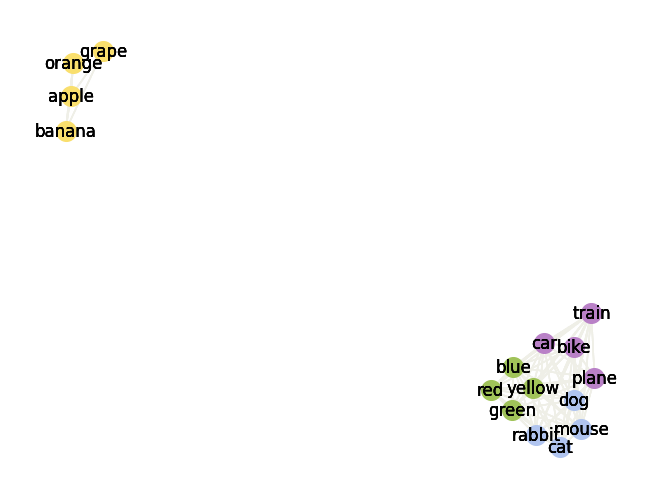

┌─────────────────────────────────────┐
│ APPLE    BANANA    ORANGE    GRAPE  │
│ BLUE     RED       GREEN     YELLOW │
│ DOG      CAT       MOUSE     RABBIT │
│ CAR      TRAIN     PLANE     BIKE   │
└─────────────────────────────────────┘


In [11]:
words = [
    "apple", "banana", "orange", "grape",
    "blue", "red", "green", "yellow",
    "car", "train", "plane", "bike",
    "dog", "cat", "mouse", "rabbit"
]

solver = NYTConnectionsSolver(words, attention_model=model)
initial_groups = solver.suggest_partition()
solver.visualize()
solver.print_board()


# inputing a correct guess:
solver.input_guess(["apple", "banana", "orange", "grape"])

new_groups = solver.suggest_partition()
solver.visualize()
solver.print_board()


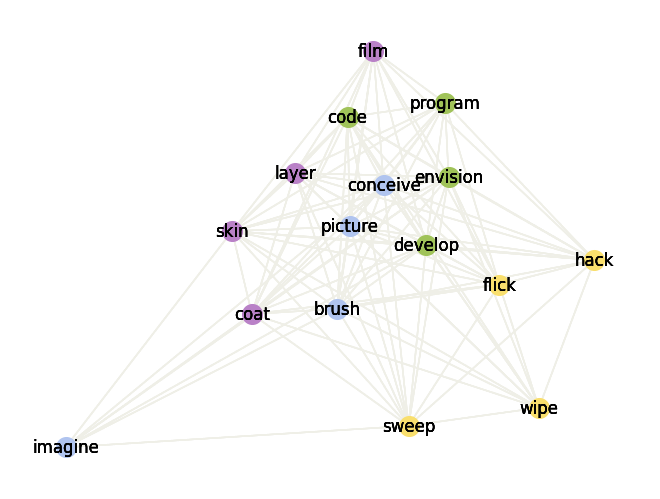

┌────────────────────────────────────────────┐
│ SWEEP      FLICK       WIPE        HACK    │
│ COAT       BRUSH       SKIN        LAYER   │
│ IMAGINE    CONCEIVE    ENVISION    DEVELOP │
│ FILM       PICTURE     PROGRAM     CODE    │
└────────────────────────────────────────────┘


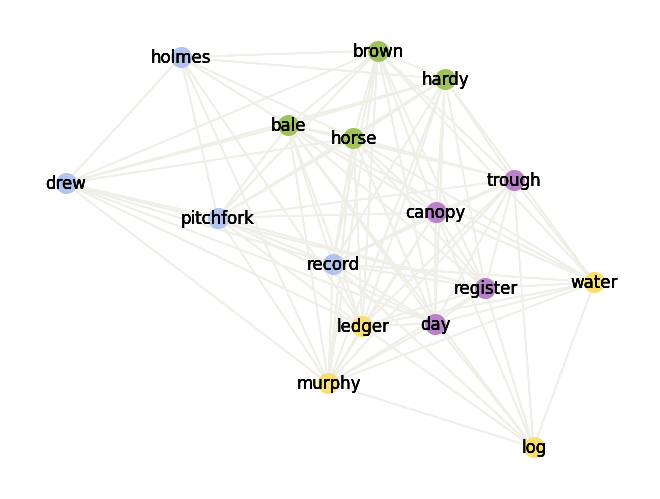

┌───────────────────────────────────────────┐
│ LEDGER    WATER     LOG          MURPHY   │
│ BROWN     HORSE     HARDY        BALE     │
│ DREW      HOLMES    PITCHFORK    RECORD   │
│ DAY       CANOPY    TROUGH       REGISTER │
└───────────────────────────────────────────┘


In [12]:
games = [
    ["coat", "brush", "develop", "film",
    "sweep", "picture", "skin", "flick",
    "imagine", "layer", "program", "code",
    "wipe", "conceive", "hack", "envision"],
    
    ["LEDGER", "DAY", "BROWN", "HORSE",
    "WATER", "HARDY", "LOG", "MURPHY",
    "BALE", "DREW", "CANOPY", "RECORD",
    "TROUGH", "REGISTER", "HOLMES", "PITCHFORK"]
]

for game in games:
    solver = NYTConnectionsSolver(game, attention_model=model)

    solver.visualize()
    solver.print_board()